__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import os  # OS operations (read/write files/folders)

# process parallelization
from multiprocessing import Lock, Manager, Pool, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import pandas as pd  # operate with dataframes
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.2f}".format

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


__Helper functions__

In [3]:
def pbar_fork_hack(l=None):
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    if l:
        global lock
        lock = l
    print(" ", end="", flush=True)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("../participants_clean.csv", keep_default_na=False)
parts = parts.set_index("id")  # set uid column as index (remove default)
parts

,date,expo,side,condition,questionnaire
id,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No
...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No


__Read questionnaire cleaned data__

In [5]:
quests = pd.read_csv("../questionnaires.csv", keep_default_na=False)
quests = quests.set_index("id")  # set uid column as index (remove default)
quests

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,side,condition
id,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,right,RadioTalk
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,left,RadioTalk
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,right,RadioTalk
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,right,TaxiDriver
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,right,RadioTalk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,right,RadioTalk
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,right,TaxiDriver
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,right,RadioTalk


In [6]:
files_old = os.listdir("../data/raw/CsvData_old")

for f in files_old:  # iterate over files
    # remove hidden/config files and folders
    if not f.endswith(".csv"):
        files_old.remove(f)

uids_old = list(set([f.split("-")[2].split(".")[0] for f in files_old]))

files_new = os.listdir("../data/raw/CsvData_new")

for f in files_new:  # iterate over files
    # remove hidden/config files and folders
    if not f.endswith(".csv"):
        files_new.remove(f)

uids_new = list(set([f.split("-")[2].split(".")[0] for f in files_new]))

clean_uids = parts.index.tolist()

uids_test = [uid for uid in clean_uids if uid in uids_old and uid in uids_new]

len(uids_test)

20266

In [7]:
def get_perc_valid(uid):
    """Description."""
    sel = parts.loc[uid]
    file = f"Path_ MS Wissenschaft-{sel.condition}-{uid}.csv"
    old = pd.read_csv(f"../data/raw/CsvData_old/{file}")
    new = pd.read_csv(f"../data/raw/CsvData/{file}")
    fin = pd.read_csv(f"../data/raw/CsvData_new/{file}")
    total = fin.index.size
    val_old = old[~pd.isnull(old.centerHit)].index.size
    val_new = new[~pd.isnull(new.hitObjectNames)].index.size
    val_fin = fin[~pd.isnull(fin.hitObjectNames)].index.size
    val_old_p = val_old * 100 / total
    val_new_p = val_new * 100 / total
    val_fin_p = val_fin * 100 / total
    lock.acquire()
    res[uid]["%valOld"] = val_old_p
    res[uid]["%valNew"] = val_new_p
    res[uid]["%valFinal"] = val_fin_p
    lock.release()


manager = Manager()  # manage shared memory types

# convert into memory-shared dict of lists for multiprocessing
res = manager.dict(
    {
        uid: manager.dict(
            {"%valOld": None, "%valNew": None, "%valFinal": None}
        )
        for uid in uids_test
    }
)

# multiprocessing lock to avoid raicing conditions
l = Lock()

# initialize pool of processes according to the available cpu core threads
pool = Pool(processes=CORES, initializer=pbar_fork_hack, initargs=(l,))

# test participants progress bar
parts_pbar = tqdm(
    iterable=pool.imap(func=get_perc_valid, iterable=uids_test),
    total=len(uids_test),
    desc="📂 test participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_pbar:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()

📄 0 of 20266 📂 test participants processed:                                                                   …

In [8]:
test = dict(res)

test = {k: dict(v) for k, v in res.items()}

test = pd.DataFrame(test)
test = test.transpose()

In [9]:
test

,%valOld,%valNew,%valFinal
4f583872ffed48249874b00f3d389cfc,68.96,93.26,93.26
33d68ad55ef544fab9fd08108e3913ca,8.65,99.78,99.78
8598a83e2af441b8bcd0ae5d84beb875,58.29,53.76,53.76
37d7e67934974217830bb429bba7fd76,87.16,91.99,91.95
42bac596059749b5b8e8e83ae61de9b4,80.46,74.24,73.12
...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,67.02,65.82,65.82
611d35a7c3e940cc82495e53c2a8532d,75.14,92.59,92.59
3b6fda285d9e412eb081986b2f22a2e3,35.90,93.00,92.85
18ffb0abdc8642098c479380bfa533d1,72.71,86.18,86.11


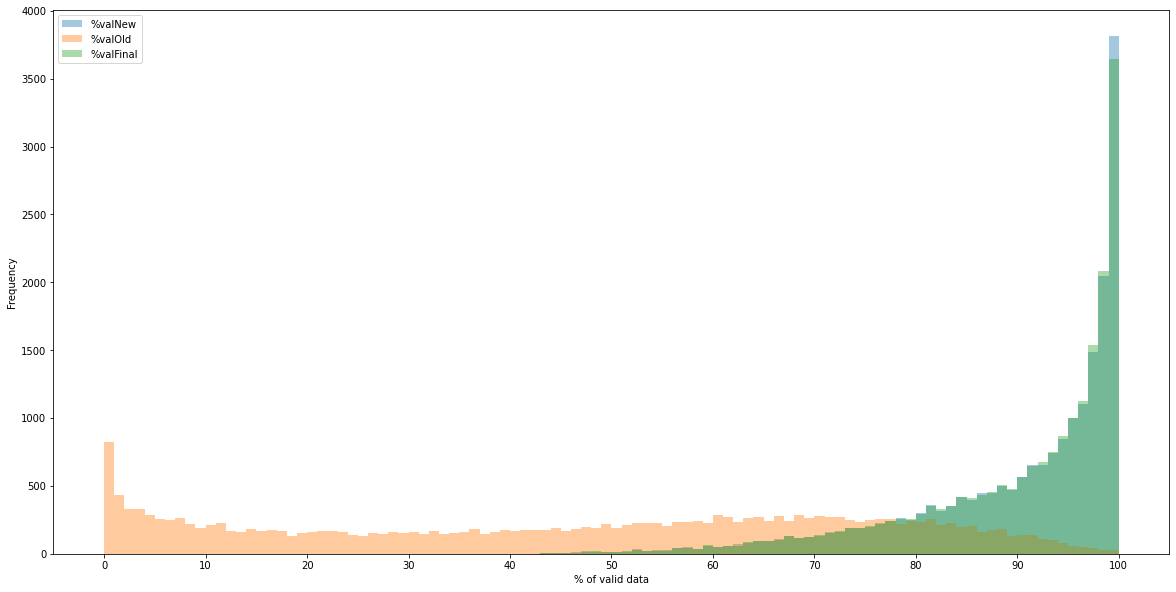

In [10]:
ax = test[["%valNew", "%valOld", "%valFinal"]].plot.hist(
    figsize=(20, 10), alpha=0.4, bins=100
)
ax.set_xticks([i * 10 for i in range(0, 11)])
ax.set_xlabel("% of valid data")
plt.show()